# Group 39 Project Report

## *Tennis Win Prediction*

**Introduction:** The Association of Tennis Professionals (ATP) is the sport governing body of tennis for men’s professional tennis competitions in the world. Statistics of all matches in the ATP competitions are recorded annually including the match location, match draw size, player’s statistics etc. 

<img src="download.png" width = "200"/>

Our target dataset of interest is the list of ATP tennis matches from the year 2022 in the world. Since many factors - age or height can determine the prospect of a player’s match win or loss, our analysis aims to study all the players' statistics to predict the win-loss probability of a tennis player from 2022. Our current dataset involves a list of player results from 2022, where sex is a constant variable that is not a relevant factor, while environmental factors such as previous training conditions and experience, cannot be accurately measured to be utilized in the analysis. As a result, we can only assess the results of tennis matches in 2022 based on age and height. Given that age and height are significant factors that affect motor performance and are often used as sport performance metrics, we can infer that a tennis player's rate of winning may be highly correlated to age and height. Therefore, through this project, we will be answering the question: 

*Within the year 2022, how likely will a player win against other tennis players in the world given the target player's age and height?*

## Methods & Results

### Installing Necessary Packages:

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### Loading Data from the original source

Below are two ways to view data from the web, from is directly reading from the csv, the other is downloading it first then viewing. 
For our data wrangling, we will be using the tennis_data, where the data is downloaded and then read (The TA mentioned this was fine for our purposes). 

In [3]:
url <- "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2022.csv"

#Reading Data from the Web -> To show that our data can be read directly from the web
web_tennis_data <- read_csv(url)
glimpse(web_tennis_data)

#Downloading the data from the web to view it
destfile <- "data/atp_matches_2022.csv"
download.file(url, destfile)
tennis_data <- read_csv("data/atp_matches_2022.csv")
tennis_data

Rows: 2917 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 2,917
Columns: 49
$ tourney_id         <chr> "2022-8888", "2022-8888", "2022-8888", "2022-8888",…
$ tourney_name       <chr> "Atp Cup", "Atp Cup", "Atp Cup", "Atp Cup", "Atp Cu…
$ surface            <chr> "Hard", "Hard", "Hard", "Hard", "Hard", "Hard", "Ha…
$ draw_size          <dbl> 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,…
$ tourney_level      <chr> "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "…
$ tourney_date       <dbl> 20220103, 20220103, 20220103, 20220103, 20220103, 2…
$ match_num          <dbl> 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 2…
$ winner_id          <dbl> 200000, 133430, 105138, 105807, 106421, 133430, 134…
$ winner_seed        <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ winner_entry       <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ winner_name        <chr> "Felix Auger Aliassime", "Denis Shapovalov", "Rober…
$ winner_hand        <chr> "R", "L", "R", "R", "R", "L", "R", "R", "R", "R", "…
$ winner_ht     

Rows: 2917 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-8888,Atp Cup,Hard,16,A,20220103,300,200000,NA,NA,⋯,50,32,7,10,3,5,11,3308,19,2260
2022-8888,Atp Cup,Hard,16,A,20220103,299,133430,NA,NA,⋯,33,21,8,9,3,6,14,2475,20,2230
2022-8888,Atp Cup,Hard,16,A,20220103,298,105138,NA,NA,⋯,80,62,20,16,6,7,19,2260,9,3706
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4,D,20220304,1,138846,NA,NA,⋯,54,29,8,11,6,10,1059,10,1881,1
2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4,D,20220304,2,209409,NA,NA,⋯,39,24,7,10,5,9,1050,10,NA,NA
2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4,D,20220304,4,208414,NA,NA,⋯,34,24,13,10,5,8,NA,NA,NA,NA


### Data Wrangling:

* __First, we must create a new data set with the players that have won their match:__
    - We do this by using select, and then renaming.
    - Finally, by using mutate, we create a new column named "results" that just says that these players are winners.
* __Now, we repeat step one, but this time for players that have lost their match__
* __Then, we create our tidy data frame through these steps:__
    - First, we use the rbind function to combine the two dataframes into one.
    - Then, we filter out the NA/Missing data values.
    - Using mutate, we first used as_factor to turn the character values of results into factors then we used as.numeric to convert the factors into numbers, which turned “win” into 1 and “lose” into 2. Since we want the range to be from 0 to 1, we used mutate to subtract the values by 1 turning “win” into01 and “lose” into 1.
    - We then group by name and height for summarizing to calculate the rate of losing by taking the average of the results as well as calculating the mean age by taking the average of the ages
    - Then, we ungroup the data so that we are able to filter out players that have played less than 5 matches in 2022.
    - We know that "1 - rate_of_losing" is simply just the rate_of_winning, so we use mutate to create that.
    - Finally, we get rid of unncessary columns, which in our case is rate_of_losing and matches_played, for we aren't planning to focus on it for our regression purposes.

`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


name,ht,mean_age,rate_of_winning
<chr>,<dbl>,<dbl>,<dbl>
Adrian Mannarino,183,33.87037,0.5185185
Albert Ramos,188,34.31923,0.4807692
Alejandro Davidovich Fokina,183,22.91277,0.4468085
⋮,⋮,⋮,⋮
Yosuke Watanuki,180,24.04286,0.4285714
Zhizhen Zhang,193,25.92222,0.5555556
Zizou Bergs,185,22.95714,0.1428571


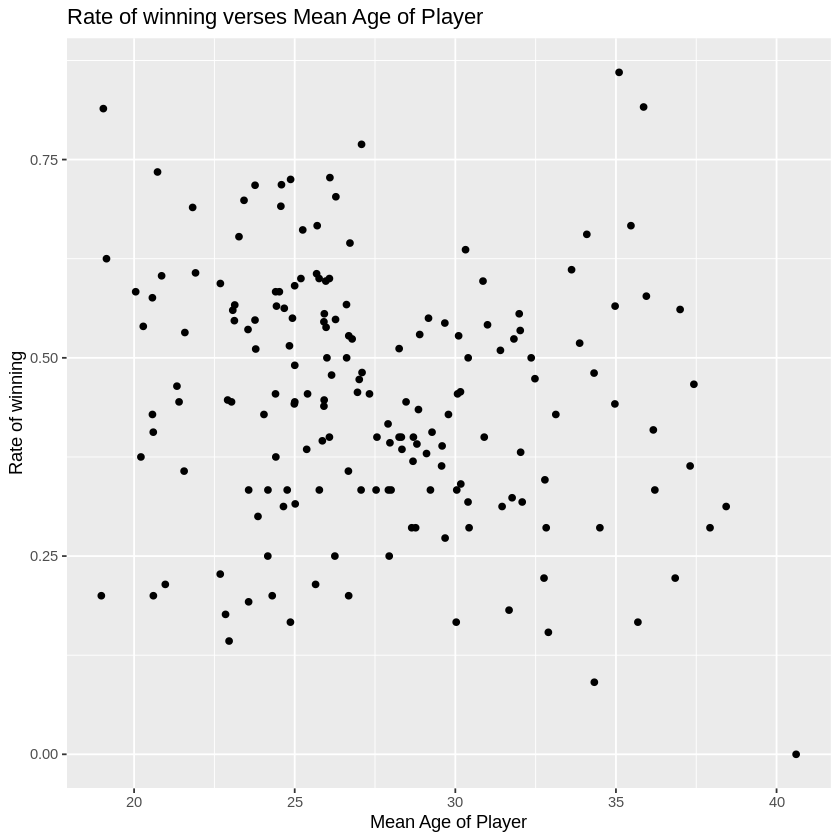

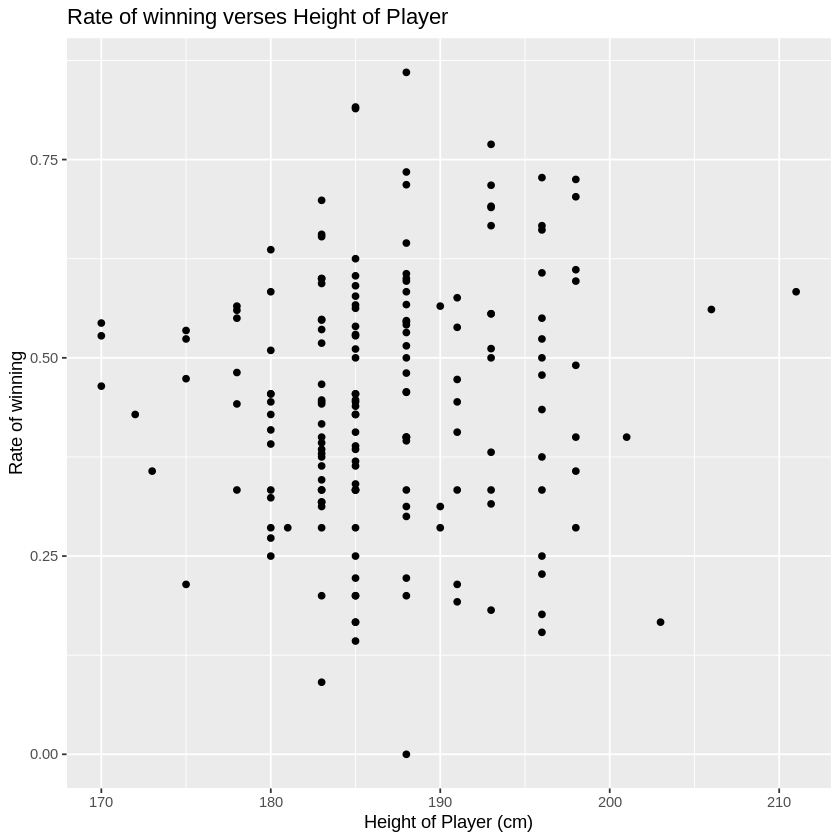

In [5]:
player_stats_winners<-tennis_data|> select(winner_age, winner_ht, winner_name)|>
    rename(
    age = winner_age,
    ht = winner_ht,
    name = winner_name)|>
    mutate(results = "win")


player_stats_losers<- tennis_data |> 
    select(loser_age, loser_ht, loser_name)|>
    rename(
    age = loser_age,
    ht = loser_ht,
    name = loser_name)|>
    mutate(results = "lose") 


player_stats <- rbind(player_stats_winners, player_stats_losers)|>
    filter(age!="NA", ht!="NA")|>
    mutate(results = as_factor(results))|>
    mutate(results = as.numeric(results))|>
    mutate(results = results-1)|>
    group_by(name, ht)|>           
    summarize(rate_of_losing=mean(results), mean_age=mean(age), matches_played = n())|>
    ungroup() |>
    filter(matches_played >= 5) |>
    mutate(rate_of_winning = 1 - rate_of_losing) |>
    select(-rate_of_losing, -matches_played)

player_stats

age_graph_unscaled <- ggplot(player_stats, aes(x=mean_age, y=rate_of_winning)) +
    geom_point()+
    labs(x="Mean Age of Player", y="Rate of winning", title="Rate of winning verses Mean Age of Player")

ht_graph_unscaled <- ggplot(player_stats, aes(x=ht, y=rate_of_winning)) +
    geom_point()+
    labs(x="Height of Player (cm)", y="Rate of winning", title="Rate of winning verses Height of Player")
age_graph_unscaled
ht_graph_unscaled

# Notes
We are currently writing the final report in the project proposal document, it may be better to create a seperate document for the report.

Should we be testing both KNN and linear regression when we have already learnt than linear regression is better?

There are likely some players in our data set that have only play one or few games during 2022, this may result in skewed win rates (either way to high or way too low). We could filter our players that have played less than some number of games during the year (possibly 5) as shown below:

In [7]:
players_with_at_least_5_matches <- rbind(player_stats_winners, player_stats_losers)|>
    filter(age!="NA", ht!="NA")|>
    mutate(results = as_factor(results))|>
    mutate(results = as.numeric(results))|>
    mutate(results = results-1) |>
    group_by(name) |>
    summarize(matches_played = n()) |>
    ungroup() |>
    filter(matches_played >= 5)
players_with_at_least_5_matches

name,matches_played
<chr>,<int>
Adrian Mannarino,54
Albert Ramos,52
Alejandro Davidovich Fokina,47
⋮,⋮
Yosuke Watanuki,7
Zhizhen Zhang,9
Zizou Bergs,7


### Splitting Data
We split our data into training(70%) and testing(30%). Also, we set seed for reproducibility when we use any randomizing function.

In [8]:
set.seed(1234)
player_stats_split <- initial_split(player_stats, prop = 0.7, strata = rate_of_winning)
player_stats_training <- training(player_stats_split)
player_stats_testing <- testing(player_stats_split)
player_stats_training
player_stats_testing

name,ht,mean_age,rate_of_winning
<chr>,<dbl>,<dbl>,<dbl>
Aljaz Bedene,181,32.82857,0.2857143
Andreas Seppi,190,37.92857,0.2857143
Benoit Paire,196,32.89615,0.1538462
⋮,⋮,⋮,⋮
Taylor Fritz,193,24.56912,0.6911765
Tim Van Rijthoven,188,25.19333,0.6000000
Tommy Paul,185,24.99848,0.5909091


name,ht,mean_age,rate_of_winning
<chr>,<dbl>,<dbl>,<dbl>
Alejandro Davidovich Fokina,183,22.91277,0.4468085
Alejandro Tabilo,188,24.83636,0.5151515
Alex De Minaur,183,23.26528,0.6527778
⋮,⋮,⋮,⋮
Thanasi Kokkinakis,196,26.00294,0.5000000
Thiago Monteiro,183,27.90556,0.4166667
Ugo Humbert,188,23.85667,0.3000000


We are testing stuff lol, finding lowest RMSE value on the **training data** to determine whether to use KNN_Regression and Linear Regression

Write stuff down here, like steps, here we are just doing KNN_Regression test first (finding lowest RMSE and also optimizing RMSE)... fill in methodology to explain what I'm doing...

We calculate the means of the parameters `mean_age` and `ht` to check if will need to standardize our data. We will need to ungroup our data for this analysis.

In [9]:
train_stats <- player_stats_training|>
    ungroup() |>
    summarize(age_mean = mean(mean_age),
              ht_mean = mean(ht),
              age_sd = sd(mean_age),
              ht_sd = sd(ht)) |>
              pivot_longer(cols = age_mean:ht_sd,
                names_to = "statistic",
                values_to = "value")
                            
#Set table title
title <- "Table 3: Means and Standard Deviations in Training Data" # We should do this for all our tables
cat("\n", title, "\n")

# Print the table
train_stats


 Table 3: Means and Standard Deviations in Training Data 


statistic,value
<chr>,<dbl>
age_mean,27.548714
ht_mean,187.157025
age_sd,4.566100
ht_sd,6.941431


### Summary of exploratory data analysis
We can see that the means and standard deviations between `mean_age` and `ht` have quite a big difference meaning we will need to standardize the data in our data analysis.

## Data Analysis

### Standardize parameters
Text explaining that we are standardizing the data

In [10]:
set.seed(1234)
# Reminder what the means and SDs looked before standardization
title <- "Table 3: Means and Standard Deviations in Training Data"
cat("\n", title, "\n")

# Print the table
train_stats


# Standardizing the data
player_stats_recipe <- recipe(rate_of_winning ~ ht + mean_age, data = player_stats_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

scaled_data <- bake(player_stats_recipe, player_stats_training)

# A look at the means and SDs after standardization
standardized_stats <- scaled_data|>
    summarize(age_mean = mean(mean_age),
              ht_mean = mean(ht),
              age_sd = sd(mean_age),
              ht_sd = sd(ht)) |>
              pivot_longer(cols = age_mean:ht_sd,
                  names_to = "statistic",
                  values_to = "value")
#Set table title
title <- "Table 5: Means and Standard Deviations in Standardized Data"
cat("\n", title, "\n")

# Print the table
standardized_stats


 Table 3: Means and Standard Deviations in Training Data 


statistic,value
<chr>,<dbl>
age_mean,27.548714
ht_mean,187.157025
age_sd,4.566100
ht_sd,6.941431



 Table 5: Means and Standard Deviations in Standardized Data 


statistic,value
<chr>,<dbl>
age_mean,3.743669e-16
ht_mean,1.056963e-15
age_sd,1.000000e+00
ht_sd,1.000000e+00


The means of age and height are near zero and the standard deviations are both 1.

### Choosing K for KNN Regression
Text explaining how we are choosing K

In [11]:
set.seed(1234)
player_stats_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

player_stats_vfold <- vfold_cv(player_stats_training, v = 5, strata = rate_of_winning)

gridvals <- tibble(neighbors = seq(1, 90))

player_stats_results <- workflow() |> 
    add_recipe(player_stats_recipe) |> 
    add_model(player_stats_spec) |>
    tune_grid(resamples = player_stats_vfold, grid = gridvals) |> # if you use grid = 200, it will test for neighbours from 1:200 (same as gridvals in this case)
    collect_metrics()

player_stats_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.21672476,5,0.009870266,Preprocessor1_Model01
1,rsq,standard,0.04999557,5,0.018905357,Preprocessor1_Model01
2,rmse,standard,0.19587240,5,0.011281362,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
89,rsq,standard,0.03299468,5,0.020184670,Preprocessor1_Model89
90,rmse,standard,0.15504709,5,0.004133783,Preprocessor1_Model90
90,rsq,standard,0.04100857,5,0.027817816,Preprocessor1_Model90


Find minimum RMSE value and also the most optimum K neighbor to use if we decided to use KNN regression:

In [12]:
player_stats_min <- player_stats_results |>
   filter(.metric == "rmse") |>
   arrange(mean) |> 
   head(1)

player_stats_min


k_min <- player_stats_min |>
         pull(neighbors)

k_min #In case we decide to use KNN regression

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
89,rmse,standard,0.1549169,5,0.004173558,Preprocessor1_Model89


[1] 89

### Fitting a Linear Regression model

In [13]:
set.seed(1234)

# your code here
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

player_stats_recipe <- recipe(rate_of_winning ~ mean_age + ht, data = player_stats_training)

player_stats_fit <- workflow() |>
  add_recipe(player_stats_recipe) |>
  add_model(lm_spec) |>
  fit(data = player_stats_training)

#### Finding RMSE value for Linear Regression (Should we be doing this on training data?)

In [14]:
lm_rmse <- player_stats_fit |>
        predict(player_stats_training) |>
        bind_cols(player_stats_training) |>
        metrics(truth = rate_of_winning, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()

# your code here
lm_rmse

[1] 0.1539307

### KNN vs. Linear Regression RMSE
We can see that the RMSE of Linear Regression(0.2547257) is lower than KNN-regression(0.2560363), thus, we should use Linear Regression for our model. 

### Calculating RMSE for Linear Regression
Text explaining how we are getting test results

In [15]:
player_stats_test_results <- player_stats_fit |>
  predict(player_stats_testing) |>
  bind_cols(player_stats_testing) |>
  metrics(truth = rate_of_winning, estimate = .pred)

player_stats_test_results

#for just the rmpse value, but it's already shown in the tibble
lm_rmspe <- player_stats_test_results |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.15374696
rsq,standard,0.08824586
mae,standard,0.12049996


[1] 0.153747

## Visualization

`geom_smooth()` using formula = 'y ~ x'


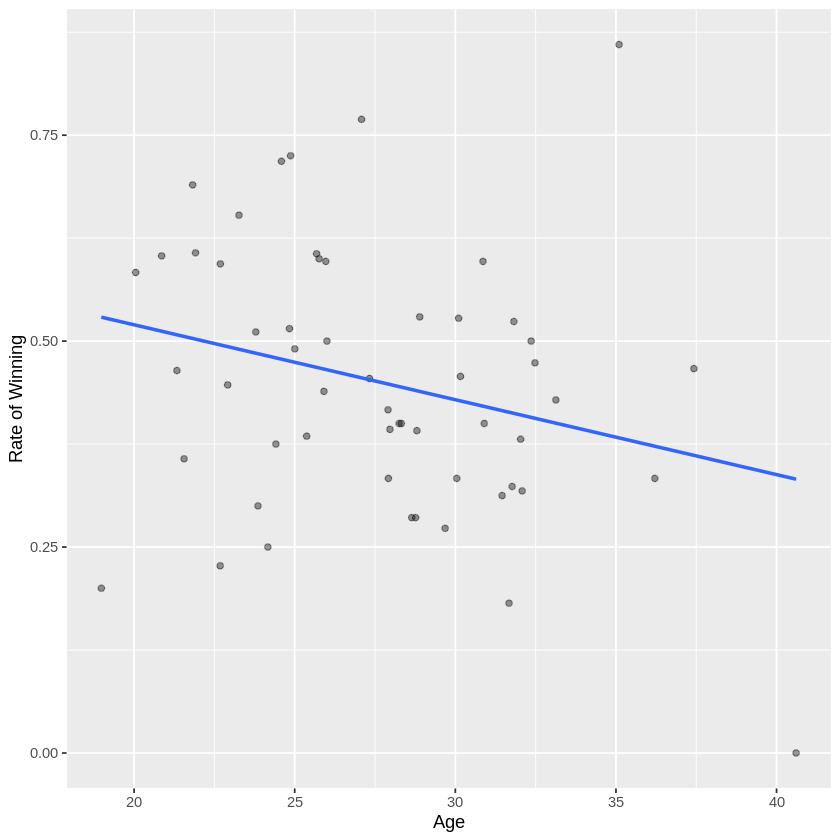

In [16]:
player_stats_final <- ggplot(player_stats_testing, aes(x = mean_age, y = rate_of_winning)) +
  geom_point(alpha = 0.4) +
  xlab("Age") +
  ylab("Rate of Winning") +
  geom_smooth(method = "lm", se = FALSE)
player_stats_final

The other graph:

`geom_smooth()` using formula = 'y ~ x'


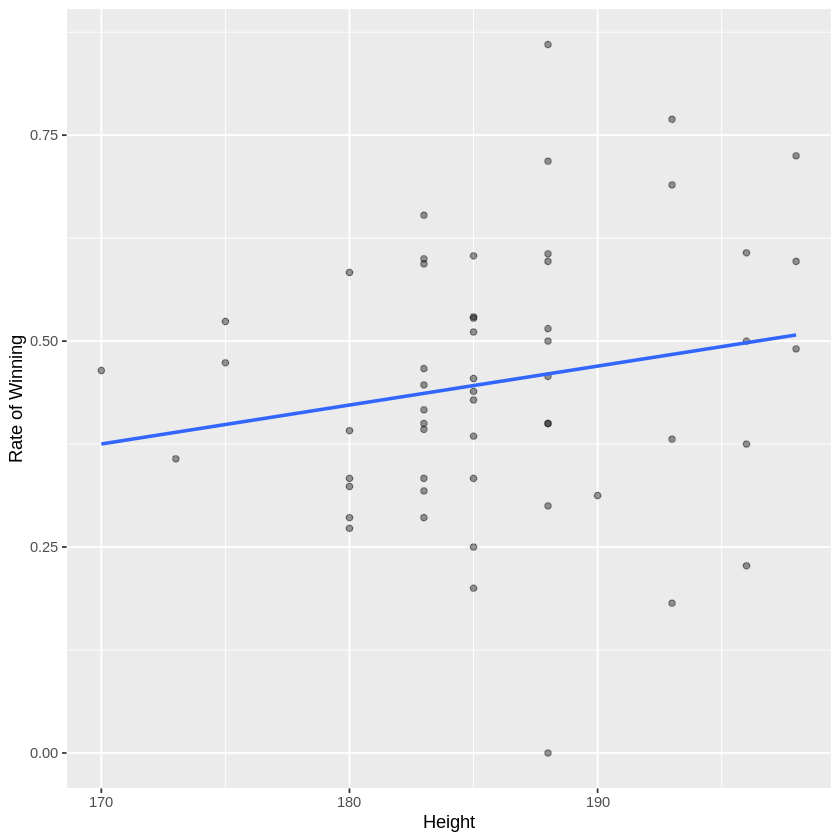

In [17]:
player_stats_final2 <- ggplot(player_stats_testing, aes(x = ht, y = rate_of_winning)) +
  geom_point(alpha = 0.4) +
  xlab("Height") +
  ylab("Rate of Winning") +
  geom_smooth(method = "lm", se = FALSE)
player_stats_final2

In case we want a pairplot of our variables to see their correlations, it is included below.

ht,mean_age,rate_of_winning
<dbl>,<dbl>,<dbl>
181,32.82857,0.2857143
190,37.92857,0.2857143
196,32.89615,0.1538462
⋮,⋮,⋮
193,24.56912,0.6911765
188,25.19333,0.6000000
185,24.99848,0.5909091


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


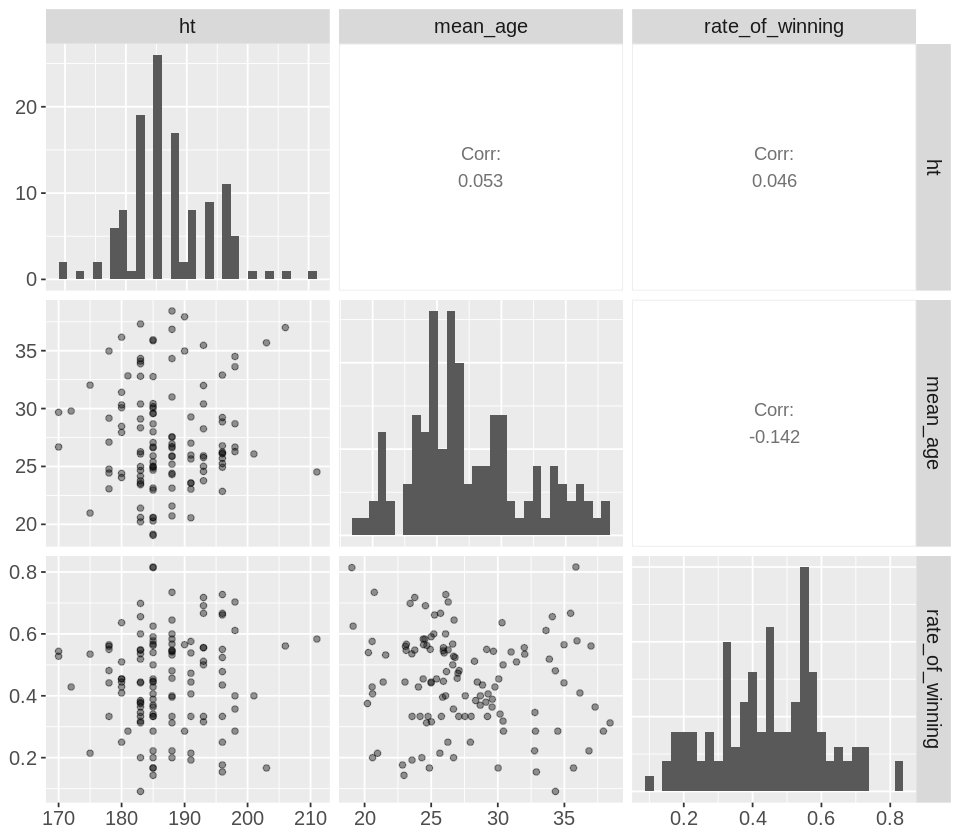

In [18]:
options(repr.plot.width = 8, repr.plot.height = 7)
player_stats_training_no_names <- player_stats_training |>
                        ungroup() |>
                        select(-name)
player_stats_training_no_names

player_pairplot <- player_stats_training_no_names |> 
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 15))

player_pairplot

## Discussion

### Summarize what we found:

As it may be clearly seen from the updated visualizations, such relations do exist between the age and height of a tennis player and the rate of winning in ATP tennis matches analyzed within the dataset of the year 2022. Findings of this study will be able to provide a captivating conversation about the means in which these physical and demographic variables may interrelate among each other towards success in winning a match.

When plotted against the rate of winning over the age, it can be clear that this chart represents the trend of moderate rates of success for middle-aged players and that the peak effectiveness could be in their late 20s or early 30s. In the scatter plot, we were able to observe a concentration of the number of wins in a cluster of data points around this age group, with different proportions of the winning rate. This means that the factor of age certainly matters, but it is moderated by other factors not taken into consideration in this analysis.

The relation between height and winning is not very clear, but it may show a trend of a larger stature winning at slightly higher rates. The visualization shows that the data points scatter at different heights; winning rates have a gentle increase trend when the heights increase. This could mean that in height, a portion of the individual gives a competitive advantage, though it would be rather small.

Thus, in general, both graphs indicated general trends through linear models but with scatter of data points that was much considerable, suggesting great variability that might be influenced by other factors such as player skill, experience, and definite match conditions besides height and age factors.

Overall, though some findings would suggest that age and height could be taken as variables affecting outcomes in tennis matches, it is not very strong or deterministic evidence.

## References

Data Source:
1. Jeff Sackmann, Tennis ATP, (2023), GitHub repository, https://github.com/JeffSackmann/tennis_atp 
https://doi.org/10.1093/ageing/29.3.235

Literature Reference: 
1. M M Samson, I B Meeuwsen, A Crowe, J A Dessens, S A Duursma, H J Verhaar, Relationships between physical performance measures, age, height and body weight in healthy adults., Age and Ageing, Volume 29, Issue 3, May 2000, Pages 235–242, https://doi.org/10.1093/ageing/29.3.235
2. Aikawa, Y., Murata, M., & Omi, N. (2020). Relationship of height, body mass, muscle mass, fat mass, and the percentage of fat with athletic performance in male Japanese college sprinters, distance athletes, jumpers, throwers, and decathletes. The Journal of Physical Fitness and Sports Medicine, 9(1), 7–14. https://doi.org/10.7600/jpfsm.9.7 